<a href="https://colab.research.google.com/github/alik604/MNIST_Brain/blob/master/MNIST_Brain_colab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NMIST Brain 

### - by Khizr Ali Pardhan [alik604](https://github.com/alik604/ReadMe)


notes:

* can use pad sequences to use all data, as it is not square
* try HMM and other stats-type models 
* try bi direction LSTM or GRU
* [LSTM/GRU - CNN (cov1D)](https://keras.io/examples/imdb_cnn_lstm/)
* try the above with attensino 



In [1]:
import pandas as pd 
import numpy as np 

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import * 

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

import keras
from keras import regularizers
from keras.models import Model, load_model, Sequential
from keras.layers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.constraints import max_norm
from keras.preprocessing import sequence
from keras.utils import to_categorical

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

Using TensorFlow backend.


## Get data

In [0]:
url = 'https://raw.githubusercontent.com/alik604/MNIST_Brain/master/MW%20-%20Copy.csv'
raw = pd.read_csv(url,low_memory=False,header= None)

FILE FORMAT:

The data is stored in a very simple text format including:

[id]: a numeric, only for reference purposes.

[event] id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

[device]: a 2 character string, to identify the device used to capture the signals, "MW" for MindWave....

[channel]: a string, to indentify the 10/20 brain location of the signal ....MindWave "FP1"

[code]: a integer, to indentify the digit been thought/seen, with possible values 0,1,2,3,4,5,6,7,8,9 or -1 for random captured signals not related to any of the digits.

[size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

[data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN.

There is no headers in the files,  every line is  a signal, and the fields are separated by a tab

In [3]:
raw.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874
0,25253\t25253\tMW\tFP1\t1\t952\t152,154,155,148,136,137,129,104,91,99,101,88,82,92,102,99,88,89,104,117,118,117,114,113,112,106,104,106,108,99,88,91,106,106,85,69,74,86,90,88,...,1098,1064,1030,995,960,925,896,865,833,803,773,745,721,696,674,650,629,608,585,564,544,524,506,488,470,453,438,423,404,373,323,249,156,48,-92,-302,-601,-901,-1157,-1364
1,4279\t4279\tMW\tFP1\t0\t952\t1261,1209,1158,1116,1090,1073,1059,1033,1003,967,930,892,845,789,762,778,773,721,660,617,589,568,539,507,487,486,485,482,469,441,409,371,324,274,237,219,199,183,166,138,...,-49,-55,-62,-61,-59,-67,-81,-90,-93,-93,-98,-107,-120,-134,-149,-165,-177,-179,-181,-181,-174,-179,-195,-212,-237,-266,-280,-301,-339,-359,-363,-380,-419,-459,-488,-494,-513,-556,-629,-702
2,46840\t46840\tMW\tFP1\t7\t889\t-6,27,37,20,8,10,3,-17,-28,-46,-74,-98,-122,-139,-152,-165,-154,-131,-122,-131,-147,-141,-102,-71,-55,-39,-27,-12,4,33,52,52,48,36,23,29,43,49,48,73,...,419,408,391,372,353,340,325,313,306,294,282,269,256,243,240,234,217,203,200,197,182,160,141,137,133,128,122,112,98,90,71,45,26,16,4,-20,-70,-137,-220,-324
3,32187\t32187\tMW\tFP1\t4\t952\t113,116,113,108,107,96,80,69,66,83,103,101,84,69,58,54,64,73,68,52,52,67,71,56,40,39,45,53,58,60,57,56,55,40,29,42,57,51,39,41,...,1178,1205,1194,1157,1114,1099,1107,1116,1128,1140,1148,1149,1146,1142,1128,1107,1080,1053,1029,1003,977,947,918,890,864,835,806,777,752,724,697,673,645,615,577,515,418,296,167,23
4,37787\t37787\tMW\tFP1\t9\t1015\t116,300,438,436,323,228,201,192,150,72,-13,-100,-156,-178,-173,-150,-107,-53,-12,-9,-41,-82,-101,-118,-117,-91,-60,-39,-22,-12,-22,-46,-70,-76,-73,-67,-66,-59,-45,-35,...,-9,85,243,317,300,230,135,76,69,50,-11,-113,-226,-322,-387,-421,-409,-349,-273,-222,-228,-227,-101,39,21,-135,-268,-306,-289,-281,-314,-404,-530,-658,-738,-774,-796,-805,-806,-825


In [4]:
# https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns
tmp = raw[0].str.split('\t').tolist()[:-1] # [:-1] means exclude last
df = pd.DataFrame(tmp,columns = ["id", "event" , "device" , "channel" , "code" , "size" , "0"] )
df.head(3)

,id,event,device,channel,code,size,0
0,25253,25253,MW,FP1,1,952,152
1,4279,4279,MW,FP1,0,952,1261
2,46840,46840,MW,FP1,7,889,-6


In [5]:
to_concat = raw[:-1].drop(0,axis=1)
to_concat.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874
0,154,155,148,136,137,129,104,91,99,101,88,82,92,102,99,88,89,104,117,118,117,114,113,112,106,104,106,108,99,88,91,106,106,85,69,74,86,90,88,77,...,1098,1064,1030,995,960,925,896,865,833,803,773,745,721,696,674,650,629,608,585,564,544,524,506,488,470,453,438,423,404,373,323,249,156,48,-92,-302,-601,-901,-1157,-1364
1,1209,1158,1116,1090,1073,1059,1033,1003,967,930,892,845,789,762,778,773,721,660,617,589,568,539,507,487,486,485,482,469,441,409,371,324,274,237,219,199,183,166,138,122,...,-49,-55,-62,-61,-59,-67,-81,-90,-93,-93,-98,-107,-120,-134,-149,-165,-177,-179,-181,-181,-174,-179,-195,-212,-237,-266,-280,-301,-339,-359,-363,-380,-419,-459,-488,-494,-513,-556,-629,-702
2,27,37,20,8,10,3,-17,-28,-46,-74,-98,-122,-139,-152,-165,-154,-131,-122,-131,-147,-141,-102,-71,-55,-39,-27,-12,4,33,52,52,48,36,23,29,43,49,48,73,128,...,419,408,391,372,353,340,325,313,306,294,282,269,256,243,240,234,217,203,200,197,182,160,141,137,133,128,122,112,98,90,71,45,26,16,4,-20,-70,-137,-220,-324


In [6]:
data = pd.concat([df,to_concat], axis =1)
data = data.drop(['device','channel'],axis =1)
data.head()

,id,event,code,size,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874
0,25253,25253,1,952,152,154,155,148,136,137,129,104,91,99,101,88,82,92,102,99,88,89,104,117,118,117,114,113,112,106,104,106,108,99,88,91,106,106,85,69,...,1098,1064,1030,995,960,925,896,865,833,803,773,745,721,696,674,650,629,608,585,564,544,524,506,488,470,453,438,423,404,373,323,249,156,48,-92,-302,-601,-901,-1157,-1364
1,4279,4279,0,952,1261,1209,1158,1116,1090,1073,1059,1033,1003,967,930,892,845,789,762,778,773,721,660,617,589,568,539,507,487,486,485,482,469,441,409,371,324,274,237,219,...,-49,-55,-62,-61,-59,-67,-81,-90,-93,-93,-98,-107,-120,-134,-149,-165,-177,-179,-181,-181,-174,-179,-195,-212,-237,-266,-280,-301,-339,-359,-363,-380,-419,-459,-488,-494,-513,-556,-629,-702
2,46840,46840,7,889,-6,27,37,20,8,10,3,-17,-28,-46,-74,-98,-122,-139,-152,-165,-154,-131,-122,-131,-147,-141,-102,-71,-55,-39,-27,-12,4,33,52,52,48,36,23,29,...,419,408,391,372,353,340,325,313,306,294,282,269,256,243,240,234,217,203,200,197,182,160,141,137,133,128,122,112,98,90,71,45,26,16,4,-20,-70,-137,-220,-324
3,32187,32187,4,952,113,116,113,108,107,96,80,69,66,83,103,101,84,69,58,54,64,73,68,52,52,67,71,56,40,39,45,53,58,60,57,56,55,40,29,42,...,1178,1205,1194,1157,1114,1099,1107,1116,1128,1140,1148,1149,1146,1142,1128,1107,1080,1053,1029,1003,977,947,918,890,864,835,806,777,752,724,697,673,645,615,577,515,418,296,167,23
4,37787,37787,9,1015,116,300,438,436,323,228,201,192,150,72,-13,-100,-156,-178,-173,-150,-107,-53,-12,-9,-41,-82,-101,-118,-117,-91,-60,-39,-22,-12,-22,-46,-70,-76,-73,-67,...,-9,85,243,317,300,230,135,76,69,50,-11,-113,-226,-322,-387,-421,-409,-349,-273,-222,-228,-227,-101,39,21,-135,-268,-306,-289,-281,-314,-404,-530,-658,-738,-774,-796,-805,-806,-825


### Droped 'device' and 'channel', since they are of not in use. this dataset is single channel
... I am using *MindWave*

#### Now its time to give a shit about the data we are working with... rather than treating it as 'just data'

[event]: id, a integer, used to distinguish the same event captured at different brain locations, used only by multichannel devices (all except MW).

[size]: a integer, to identify the size in number of values captured in the 2 seconds of this signal, since the Hz of each device varies, in "theory" the value is close to 512Hz for MW, 128Hz for EP, 220Hz for MU & 128Hz for IN, for each of the 2 seconds.

[data]: a coma separated set of numbers, with the time-series amplitude of the signal, each device uses a different precision to identify the electrical potential captured from the brain: integers in the case of MW & MU or real numbers in the case of EP & IN.

### I have truncated the data in excel to make it square (not a *jagged* array) 
* event is of no use
* size appears to be of non use 
* I see no point in keeping ID 

**I have no clue what to do with [data]...**


[data - proper definition]: a time-series signal, where the y-axis is the voltage.... its that fucking simple, no need for big words 

**I'm going back and labeling *data* as 0**

In [7]:
df = data.drop(['id','event','size'],axis =1)
df.head(5)

,code,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874
0,1,152,154,155,148,136,137,129,104,91,99,101,88,82,92,102,99,88,89,104,117,118,117,114,113,112,106,104,106,108,99,88,91,106,106,85,69,74,86,90,...,1098,1064,1030,995,960,925,896,865,833,803,773,745,721,696,674,650,629,608,585,564,544,524,506,488,470,453,438,423,404,373,323,249,156,48,-92,-302,-601,-901,-1157,-1364
1,0,1261,1209,1158,1116,1090,1073,1059,1033,1003,967,930,892,845,789,762,778,773,721,660,617,589,568,539,507,487,486,485,482,469,441,409,371,324,274,237,219,199,183,166,...,-49,-55,-62,-61,-59,-67,-81,-90,-93,-93,-98,-107,-120,-134,-149,-165,-177,-179,-181,-181,-174,-179,-195,-212,-237,-266,-280,-301,-339,-359,-363,-380,-419,-459,-488,-494,-513,-556,-629,-702
2,7,-6,27,37,20,8,10,3,-17,-28,-46,-74,-98,-122,-139,-152,-165,-154,-131,-122,-131,-147,-141,-102,-71,-55,-39,-27,-12,4,33,52,52,48,36,23,29,43,49,48,...,419,408,391,372,353,340,325,313,306,294,282,269,256,243,240,234,217,203,200,197,182,160,141,137,133,128,122,112,98,90,71,45,26,16,4,-20,-70,-137,-220,-324
3,4,113,116,113,108,107,96,80,69,66,83,103,101,84,69,58,54,64,73,68,52,52,67,71,56,40,39,45,53,58,60,57,56,55,40,29,42,57,51,39,...,1178,1205,1194,1157,1114,1099,1107,1116,1128,1140,1148,1149,1146,1142,1128,1107,1080,1053,1029,1003,977,947,918,890,864,835,806,777,752,724,697,673,645,615,577,515,418,296,167,23
4,9,116,300,438,436,323,228,201,192,150,72,-13,-100,-156,-178,-173,-150,-107,-53,-12,-9,-41,-82,-101,-118,-117,-91,-60,-39,-22,-12,-22,-46,-70,-76,-73,-67,-66,-59,-45,...,-9,85,243,317,300,230,135,76,69,50,-11,-113,-226,-322,-387,-421,-409,-349,-273,-222,-228,-227,-101,39,21,-135,-268,-306,-289,-281,-314,-404,-530,-658,-738,-774,-796,-805,-806,-825


In [0]:
X = df.drop(['code'],axis =1)
y = df.code

X.astype = int
y.astype = int


## Preprocessing

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
y_train , y_test = y_train[1:].to_numpy(), y_test[1:].to_numpy()
X_train, X_test = X_train[1:], X_test[1:]

mms = MinMaxScaler()
X_train_trans = mms.fit_transform(X_train)
X_test_trans = mms.transform(X_test)

maxlen = 50#240
# X_train_trans_padded = sequence.pad_sequences(pd.DataFrame(X_train_trans).to_numpy(), maxlen=maxlen)
# X_test_trans_padded  = sequence.pad_sequences(pd.DataFrame(X_test_trans).to_numpy(), maxlen=maxlen)
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

seqTrain = seqTrain.reshape((-1, maxlen, 1))
seqTest = seqTest.reshape((-1, maxlen, 1))

enc = OneHotEncoder(handle_unknown='ignore')
y_train_oneHot, y_test_oneHot = enc.fit_transform(y_train.reshape(-1, 1)), enc.transform(y_test.reshape(-1, 1))

y_train_c, y_test_c= to_categorical(y_train), to_categorical(y_test)

In [10]:
print(y_train_oneHot[:5])
# print(y_train_c[:5]) # matrix 

X_train_trans.shape

  (0, 3)	1.0
  (1, 7)	1.0
  (2, 6)	1.0
  (3, 3)	1.0
  (4, 4)	1.0


(28651, 875)

<Figure size 864x216 with 0 Axes>

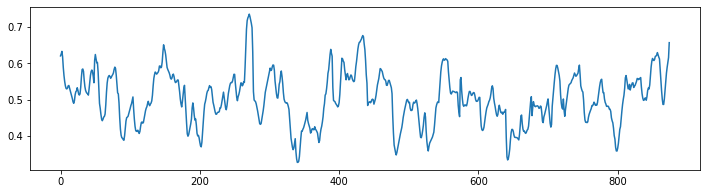

In [11]:
v = X_train_trans[0]

plt.figure(figsize=(12,3))
# plt.plot(list(range(len(v)-1)),v[1:])
plt.plot(v)

## Elementary approch

In [12]:
print(y_train[:5])
X_train.head()


['3' '7' '6' '3' '4']


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,835,836,837,838,839,840,841,842,843,844,845,846,847,848,849,850,851,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874
26398,8,-3,-7,-7,-7,-4,0,2,10,27,34,26,16,3,-2,-8,-17,-25,-42,-56,-53,-43,-39,-30,-19,-6,5,19,26,37,50,59,58,53,43,41,45,49,48,49,...,1,0,7,29,56,67,54,39,32,34,41,40,29,29,37,48,51,48,42,37,29,26,37,44,41,49,54,48,36,34,29,22,24,35,39,33,20,19,35,43
22004,27,53,56,34,10,13,26,23,17,13,16,20,25,29,22,7,4,7,6,9,18,25,25,20,26,42,44,33,22,24,34,32,20,3,-1,2,3,16,37,38,...,28,48,56,51,53,67,75,77,74,65,44,28,16,1,4,37,80,107,109,90,65,43,35,42,45,38,36,34,25,7,-2,8,33,42,39,28,27,29,39,50
18517,54,52,51,50,34,16,12,27,41,43,37,26,23,22,9,2,3,4,9,21,26,23,22,26,21,18,24,32,38,51,60,65,59,51,43,42,49,43,37,24,...,40,39,38,45,56,67,67,55,51,51,52,55,60,65,54,38,28,25,29,25,17,22,40,50,40,29,22,20,19,13,10,7,9,20,24,24,19,16,25,39
31615,87,80,74,76,73,60,40,21,16,16,21,32,38,32,8,3,20,38,40,35,25,24,41,53,57,51,38,22,9,-2,-7,-8,0,16,20,5,-6,4,24,39,...,1,12,17,8,-3,-4,-6,-12,-11,-3,6,-4,-24,-30,-22,-10,2,11,3,-8,-14,-13,-9,-5,-2,8,5,-8,-10,4,22,33,57,71,55,41,50,68,74,69
20444,43,53,51,36,18,11,24,27,18,19,28,35,33,26,22,12,6,2,-4,-5,2,8,17,12,6,20,40,55,55,41,25,24,38,51,65,64,54,51,54,56,...,21,16,16,16,16,8,-5,-3,11,22,21,12,5,7,16,22,28,26,27,28,23,17,7,5,19,32,36,39,28,21,33,42,27,9,2,-2,2,9,13,11


In [97]:
# clf = MLPClassifier(solver='lbfgs',hidden_layer_sizes=(500,1000,500,100,10), alpha=1e-5, random_state=1,verbose =True)
# clf.fit(X_train, y_train)

# pred = clf.predict(X_test)
# score = clf.score(X_test,y_test)
# print('\n', score)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(500, 1000, 500, 100, 10),
              learning_rate='constant', learning_rate_init=0.001, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=True,
              warm_start=False)


 0.10290421669924601


In [0]:
# print(list(pred[:15]))

In [0]:
# metric = y_test==pred
# metric = metric.to_list()

# t = metric.count(True)
# f = metric.count(False)

# print( round(t / (t+f),3), "% are correct")


def benchmark(pred, y_test = y_test):
  print( "hamming_loss: \t\t"    ,round(hamming_loss(y_test,pred),3))
  print( "precision_score: \t"   ,round(precision_score(y_test,pred,average='micro'),3))
  print( "recall_score: \t\t"    ,round(recall_score(y_test,pred ,average='micro'),3))
  print("------------------------------")
  print( "accuracy_score: \t"    ,round(accuracy_score(y_test,pred),3))

# benchmark(pred)

In [98]:
DTC = DecisionTreeClassifier() 
RFC = RandomForestClassifier(n_estimators=25, random_state=1)
ETC = ExtraTreesClassifier(n_estimators=10, criterion='gini', max_features='auto', bootstrap=False)

eclf = VotingClassifier(estimators=[('lr', DTC), ('rf', RFC),('et',ETC)], voting='hard') 
# for clf, label in zip([DTC, RFC,ETC, eclf], ['DecisionTreeClassifier', 'RandomForestClassifier', 'ExtraTreesClassifier', 'Ensemble']): 
#     _ = eclf.fit(X_train,y_train)
#     pred = eclf.score(X_test,y_test)
#     print("Acc: %0.10f [%s]" % (pred,label))

# _ = eclf.fit(X_train,y_train)
# print(eclf.score(X_test,y_test))

# pred = eclf.predict(X_test)
# tmp = y_test[:15]

# print(pred[:15])
# print(tmp)

0.0967606813739179
['0' '0' '1' '5' '2' '0' '4' '4' '0' '3' '1' '7' '0' '1' '1']
['7' '6' '4' '5' '1' '8' '2' '9' '7' '9' '3' '0' '6' '2' '9']


```
* Acc: 0.1008280565 [DecisionTreeClassifier]
* Acc: 0.1022893327 [RandomForestClassifier]
* Acc: 0.1081344374 [ExtraTreesClassifier]
* Acc: 0.1074037993 [Ensemble]
```

In [0]:
# from sklearn.tree import ExtraTreeClassifier
# '''
# SGDClassifier# .10 doesnt work 
# ComplementNB # .10 doesnt work 
# GaussianNB   # .10 doesnt work 
# ExtraTreeClassifier # .10 doesnt work 
# '''

# clf = ExtraTreeClassifier()
# _ = clf.fit(X_train_trans,y_train)

# print('\n Acc: ',eclf.score(X_test_trans,y_test))

# pred = eclf.predict(X_test_trans)
# print(pred[:15])
# print(y_test[:15])

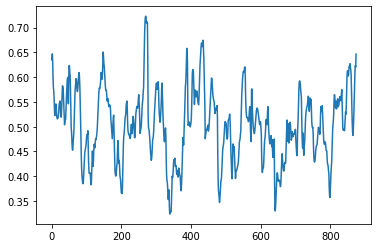

In [21]:
plt.plot(X_test_trans[0])
# test = X_test_trans[0]
# test=test.reshape(-1,1)

### Basic ANN  




In [22]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
# dim = X_train.shape[1]

# classifier = Sequential()
# #First Hidden Layer
# classifier.add(Dense(50, activation='relu', input_dim=dim))
# # classifier.add(Dense(100, activation='relu'))
# # classifier.add(Dropout(0.07))
# # classifier.add(Dense(50, activation='relu' ))
# # classifier.add(Dropout(0.07))
# # classifier.add(Dense(20, activation='relu'))
# classifier.add(Dense(1, activation='softmax'))

# classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

In [0]:
# tensorboard = TensorBoard(histogram_freq=0,
#                           write_graph=True,
#                           write_images=True)

# history = classifier.fit(X_train_trans,y_train, batch_size=8, epochs=1, validation_data=(X_test_trans,y_test) , callbacks=[tensorboard]).history

In [0]:
# eval_model=classifier.evaluate(X_train_trans, y_train,verbose=0)
# print(eval_model)

# eval_model=classifier.evaluate(X_test_trans, y_test,verbose=0)
# print(eval_model)

# predictions=classifier.predict(X_test_trans)
# print(predictions)
# # predictions =(predictions>0.80)

In [0]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper right');


# fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error,pos_label=1)
# roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
# plt.legend(loc='lower right')
# plt.plot([0,1],[0,1],'r--')
# plt.xlim([-0.001, 1])
# plt.ylim([0, 1.001])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show();

In [0]:
# X_train, X_test, y_train, y_test = train_test_split(X[10000:], y[10000:], test_size=0.2, random_state=42)
# mms = MinMaxScaler()
# X_train_trans = mms.fit_transform(X_train)
# X_test_trans = mms.transform(X_test)

In [0]:
# maxlen = 952
# max_features = 200
# X.shape

# model = Sequential()
# model.add(Embedding(max_features, 128, input_length=maxlen))
# model.add(Bidirectional(GRU(64))) # LSTM
# model.add(Dropout(0.25))
# model.add(Dense(10, activation='softmax'))
# # categorical reference https://elitedatascience.com/keras-tutorial-deep-learning-in-python

# model.compile('adam', 'categorical_crossentropy', metrics=['accuracy']) # was using binary_crossentropy



# print('Train...')

# yyy = enc.transform(y_train.reshape(-1, 1))
# yy = enc.transform(y_test.reshape(-1, 1))

# model.fit(X_train_trans, yyy,
#           batch_size=32,
#           epochs=4,
#           validation_data=[X_test_trans, yy])

In [0]:
# pred = model.predict(X_test_trans)

# eval_model=model.evaluate(X_train_trans, y_train,verbose=0)
# print(eval_model)

# eval_model=model.evaluate(X_test_trans, y_test,verbose=0)
# print(eval_model)

# predictions=model.predict(X_test_trans)
# # predictions =(predictions>0.80)

# benchmark(pred)

## Try EEGModels package - fancy 1D

In [0]:
# !wget https://raw.githubusercontent.com/vlawhern/arl-eegmodels/master/EEGModels.py
# import EEGModels as EM


In [30]:
# idea from https://github.com/Cerebrock/BCI/blob/9e670f2b30cbe1e74579637bfeff1b232aa8642a/mnist.ipynb


""" Keras Implementation of EEGNet
http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta

Inputs:
    
  nb_classes      : int, number of classes to classify
  Chans, Samples  : number of channels and time points in the EEG data
  dropoutRate     : dropout fraction
  kernLength      : length of temporal convolution in first layer. We found
                    that setting this to be half the sampling rate worked
                    well in practice. For the SMR dataset in particular
                    since the data was high-passed at 4Hz we used a kernel
                    length of 32.     
  F1, F2          : number of temporal filters (F1) and number of pointwise
                    filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
  D               : number of spatial filters to learn within each temporal
                    convolution. Default: D = 2
  dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
"""

nb_classes =10
Chans = 1 #64
Samples = maxlen # was 128
dropoutRate = 0.5
kernLength = 100
F1 = 8
D = 2
F2 = 16
norm_rate = 0.25
dropoutType = 'Dropout'

if dropoutType == 'SpatialDropout2D':
    dropoutType = SpatialDropout2D
elif dropoutType == 'Dropout':
    dropoutType = Dropout
else:
    raise ValueError('dropoutType must be one of SpatialDropout2D '
                      'or Dropout, passed as a string.')

model = Sequential()
model.add(Conv2D(F1, (1,kernLength) , padding = 'same', input_shape =  (1,Samples,1), use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))
model.add(DepthwiseConv2D((Chans, 1), use_bias = False, 
                                depth_multiplier = D,
                                depthwise_constraint = max_norm(norm_rate))) # was chans = 64

model.add(Conv2D(F1, (1,kernLength) , padding = 'same', use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))
model.add(DepthwiseConv2D((Chans, 1), use_bias = False, 
                                depth_multiplier = D,
                                depthwise_constraint = max_norm(norm_rate))) # was chans = 64

model.add(BatchNormalization(axis = 1))
model.add(Activation('elu'))
model.add(AveragePooling2D((1, 2))) # 1,4 
model.add(dropoutType(dropoutRate))

model.add(SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same'))
model.add(BatchNormalization(axis = 1))
model.add(Activation('elu'))
model.add(AveragePooling2D((1, 8)))
model.add(dropoutType(dropoutRate))
model.add(Flatten(name = 'flatten'))
model.add(Dense(nb_classes, name = 'dense',kernel_constraint = max_norm(norm_rate)))
model.add(Activation('softmax')) 
# eegnet = Model(outputs=Activation('softmax', name = 'softmax'))


' Keras Implementation of EEGNet\nhttp://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta\n\nInputs:\n    \n  nb_classes      : int, number of classes to classify\n  Chans, Samples  : number of channels and time points in the EEG data\n  dropoutRate     : dropout fraction\n  kernLength      : length of temporal convolution in first layer. We found\n                    that setting this to be half the sampling rate worked\n                    well in practice. For the SMR dataset in particular\n                    since the data was high-passed at 4Hz we used a kernel\n                    length of 32.     \n  F1, F2          : number of temporal filters (F1) and number of pointwise\n                    filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. \n  D               : number of spatial filters to learn within each temporal\n                    convolution. Default: D = 2\n  dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.\n'













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [31]:
model.compile(loss="categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])

seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float', truncating='post')

seqTrain = seqTrain.reshape((-1, 1, maxlen, 1))
seqTest = seqTest.reshape((-1, 1, maxlen, 1))
# model.fit(seqTrain, y_train, batch_size = 256, validation_split=0.1, epochs = 100)
model.fit(seqTrain, y_train_oneHot, epochs=10, batch_size=128, validation_data=(seqTest,y_test_oneHot))




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 28651 samples, validate on 7162 samples
Epoch 1/10
28651/28651 [==============================] - 10s 345us/step - loss: 2.3113 - acc: 0.1014 - val_loss: 2.3025 - val_acc: 0.1025
Epoch 2/10
28651/28651 [==============================] - 3s 88us/step - loss: 2.3046 - acc: 0.0982 - val_loss: 2.3034 - val_acc: 0.0952
Epoch 3/10
28651/28651 [==============================] - 3s 89us/step - loss: 2.3038 - acc: 0.0992 - val_loss: 2.3027 - val_acc: 0.1033
Epoch 4/10
28651/28651 [==============================] - 3s 88us/step - loss: 2.3035 - acc: 0.1015 - val_loss: 2.3030 - val_acc: 0.1016
Epoch 5/10
28651/28651 [==============================] - 2s 86us/step - loss: 2.3031 - acc: 0.1037 - val_loss: 2.3032 - val_acc: 0.1026
Epoch 6/10
28651/28651 [==============================] - 3s 88us/step - loss: 2.3029 - acc: 0.1046 - val_loss: 2.3029 - val_acc: 0.1032
Epoch 7/10
28651/28651 [=====

## Try LSTM and GRU

### Stacked LSTM 

In [0]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

seqTrain = seqTrain.reshape((-1, maxlen, 1))
seqTest = seqTest.reshape((-1, maxlen, 1))

In [33]:
# https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/
# stateful-ness reference https://keras.io/getting-started/sequential-model-guide/
## 29; len/29 is a whole number, it is needed... IDK why, but thats what the error message said 

model = Sequential()
model.add(CuDNNLSTM(256,batch_input_shape=(29, maxlen, 1),stateful=True, return_sequences=True)) # ,return_sequences=True is need for deep ("stacked")
model.add(BatchNormalization())
model.add(CuDNNLSTM(150, stateful=True, return_sequences=True)) # ,return_sequences=True is need for deep ("stacked")
model.add(CuDNNLSTM(75,  stateful=True, return_sequences=False)) # ,return_sequences=True is need for deep ("stacked")
model.add(BatchNormalization())
model.add(Dense(32))
model.add(ReLU())
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (29, 50, 256)             265216    
_________________________________________________________________
batch_normalization_5 (Batch (29, 50, 256)             1024      
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (29, 50, 150)             244800    
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (29, 75)                  68100     
_________________________________________________________________
batch_normalization_6 (Batch (29, 75)                  300       
_________________________________________________________________
dense_1 (Dense)              (29, 32)                  2432      
_________________________________________________________________
re_lu_1 (ReLU)               (29, 32)                 

In [34]:
opt = keras.optimizers.RMSprop(lr=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(seqTrain, y_train_oneHot, epochs=5, batch_size=29, validation_data=(seqTest,y_test_oneHot))

ValueError: ignored

###  Stacked GRU with Embedding

* (Reference for Embedding](https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/)

In [0]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post')

# seqTrain = seqTrain.reshape((-1, maxlen))
# seqTest = seqTest.reshape((-1, maxlen))


model = Sequential()
model.add(Embedding(seqTrain.shape[0], maxlen, input_length=maxlen))
# input_length should be > maxLen? https://github.com/LuisPB7/fnc-msc/blob/master/fnc-model.py#L219

model.add(CuDNNGRU(256,return_sequences=True)) # ,return_sequences=True is need for deep 
model.add(CuDNNGRU(128))

model.add(Dense(32))
model.add(ReLU())
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['categorical_accuracy'])
model.fit(seqTrain, y_train_oneHot, epochs=4, batch_size=128, validation_data=(seqTest,y_test_oneHot))

In [0]:
pred = model.evaluate(seqTest,y_test_oneHot)
pred[1]


### Bidirectional LSTM

In [0]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen))
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen))

model = Sequential()
model.add(Embedding(seqTrain.shape[0], maxlen, input_length=maxlen))
model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(32, return_sequences=False)))
# same speed as CuDNNGRU()



model.add(Dense(32))
model.add(ReLU())
model.add(Dense(10, activation='softmax'))

# model.summary()

opt = keras.optimizers.RMSprop(lr=0.0001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(seqTrain, y_train_c, epochs=5, batch_size=64, callbacks=[chk], validation_data=(seqTest,y_test_c))

In [0]:
seqTrain[0]

### 1D CNN + Bidirectional LSTM 

In [92]:
seqTrain=sequence.pad_sequences(sequences= X_train_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen))
seqTest=sequence.pad_sequences(sequences= X_test_trans, maxlen=maxlen, padding='post', dtype='float32', truncating='post').reshape((-1, maxlen))

model = Sequential()
model.add(Embedding(seqTrain.shape[0], maxlen, input_length=maxlen))

model.add(Conv1D(F1, kernLength, padding = 'same', use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))

model.add(Conv1D(F1, kernLength, padding = 'same', use_bias= False)) # (1,Chans,Samples), use_bias= False))
model.add(BatchNormalization(axis = 1))
# model.add(Flatten())

model.add(Bidirectional(CuDNNLSTM(64,return_sequences=True)))
model.add(BatchNormalization(axis = 1))

model.add(Bidirectional(CuDNNLSTM(32, return_sequences=False)))
model.add(BatchNormalization(axis = 1))

model.add(Dense(10, name = 'dense',kernel_constraint = max_norm(norm_rate),activation='softmax'))

# model.summary()

opt = keras.optimizers.RMSprop(lr=0.0001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(seqTrain, y_train_c, epochs=20, batch_size=64, callbacks=[chk], validation_data=(seqTest,y_test_c))

ValueError: ignored

In [91]:
model.predict(seqTest)

array([[0.29786196, 0.04668574, 0.07827839, ..., 0.05150283, 0.07521413,
        0.08752518],
       [0.29786196, 0.04668574, 0.07827839, ..., 0.05150283, 0.07521413,
        0.08752518],
       [0.29786196, 0.04668574, 0.07827839, ..., 0.05150283, 0.07521413,
        0.08752518],
       ...,
       [0.29786196, 0.04668574, 0.07827839, ..., 0.05150283, 0.07521413,
        0.08752518],
       [0.29786196, 0.04668574, 0.07827839, ..., 0.05150283, 0.07521413,
        0.08752518],
       [0.29786196, 0.04668574, 0.07827839, ..., 0.05150283, 0.07521413,
        0.08752518]], dtype=float32)

## ...